# AB Testing

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)



<a id='intro'></a>
### Introduction


>To complete my Data Analysis project I am using Purchase Dataset from e-commerce website. 
>This data set contains information about 290.000 transaction collected from marketplace. It consist of 5 columns item, include of column of purchased. 
>My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


>#### **Question that can analyised from this data set**
> 1. Prob of purchase regardless of the page, of control group, and of treatment group
> 2. If i want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, What are my null and alternative hypotheses should be?
> 3. Get P-value to make a decission accept/reject null hypothesis


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [5]:
#Read in the dataset and take a look at the top few rows here:
df =pd.read_csv("purchase.csv", sep=";")
df.head()

,user_id,timestamp,group,landing_page,purchased
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
purchased       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [7]:
df.shape

(294478, 5)

In [8]:
#The number of unique users in the dataset.
df['user_id'].nunique()

290584

In [10]:
#The proportion of users purchased.
df.purchased.mean()

0.11965919355605512

In [50]:
#The number of times the new_page and treatment don't match.

df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
purchased       3893
dtype: int64

In [12]:
#Do any of the rows have missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
purchased       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


No its doesn't have any null values.

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

In [13]:
# Where treatment does not match with new_page or control does not match with old_page
i = df[((df['group']=='treatment') ==(df['landing_page']=='new_page')) == False].index

In [14]:
# Drop those rows
df2 = df.drop(i)

In [15]:
# Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [16]:
# Number of unique users in df2
df2['user_id'].nunique()

290584

In [17]:
# Number of duplicate rows
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,purchased
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [18]:
# Drop the row and keep the first row
df2.drop_duplicates(subset ='user_id',keep ='first',inplace = True)

In [21]:
# Prob of purchase regardless of the page
(df2.query('purchased == 1').purchased.count())/df2.shape[0]

0.11959708724499628

In [22]:
# Prob of purchase in control group
control_df = df2.query('group =="control"')
Pold = control_df['purchased'].mean()
Pold

0.1203863045004612

In [24]:
# Prob of purchase in treatment group
treatment_df = df2.query('group =="treatment"')
Pnew = treatment_df['purchased'].mean()
Pnew 

0.11880806551510564

In [25]:
# Prob of receiving new page
df2.query('landing_page == "new_page"').landing_page.count()/df2.shape[0]

0.5000619442226688

From the above results we cannot conclude that new treatment leads to more purchase. As per our analysis we can see that Pnew is smaller than P old.

<a id='ab_test'></a>
### Part II - A/B Test

For now, consider i need to make the decision just based on all the data provided.  If i want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, my null and alternative hypotheses are :

> H0 = Pnew <= Pold

> H1 = Pnew > Pold 

Assume under the null hypothesis,  𝑝𝑛𝑒𝑤  and  𝑝𝑜𝑙𝑑  both have "true" success rates equal to the purchased success rate regardless of page - that is  𝑝𝑛𝑒𝑤 and  𝑝𝑜𝑙𝑑  are equal. Furthermore, assume they are equal to the purchased rate in ab_data.csv regardless of the page. 

Perform the sampling distribution for the difference in purchased between the two pages over 10,000 iterations of calculating an estimate from the null.

In [51]:
#purchase rate for p_new under the null
P_new = treatment_df['purchased'].mean()
P_new

0.11880806551510564

In [52]:
#purchase rate for p_old under the null
P_old = control_df['purchased'].mean()
P_old

0.1203863045004612

In [29]:
#the number of individuals in the treatment group
n_new = treatment_df.shape[0]
n_new

145310

In [53]:
#the number of individuals in the control group
n_old = control_df.shape[0]
n_old

145274

Simulate $n_{new}$ transactions with a purchase rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_purchased**.

In [31]:
new_page_purchased = np.random.binomial(1,P_new,n_new)
new_page_purchased.mean()


0.11873924712683229

Simulate $n_{old}$ transactions with a purchase rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_purchased**.

In [32]:
old_page_purchased = np.random.binomial(1,P_old,n_old)
old_page_purchased.mean()

0.12048955766344975

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
 new_page_purchased.mean() - old_page_purchased.mean()


-0.0017503105366174637

Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [34]:
p_diffs =[]
size = df2.shape[0]
for _ in range(10000):
    new_page_purchased = np.random.binomial(1,P_new, n_new)
    old_page_purchased = np.random.binomial(1,P_old, n_old)
    p_diffs.append(new_page_purchased.mean() - old_page_purchased.mean())

Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

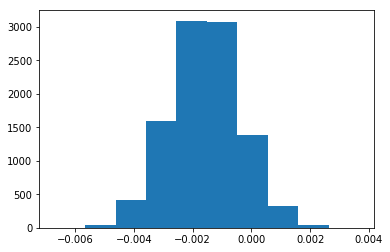

In [35]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

In [38]:
act_new_purchase = df2.query('purchased == 1 and landing_page == "new_page"')['user_id'].nunique()/n_new

In [39]:
act_old_purchase  = df2.query('purchased == 1 and landing_page == "old_page"')['user_id'].nunique()/n_old

In [41]:
obs_diff = act_new_purchase - act_old_purchase
obs_diff

-0.0015782389853555567

In [42]:
#proportion of the p_diffs are greater than the actual difference observed in data
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

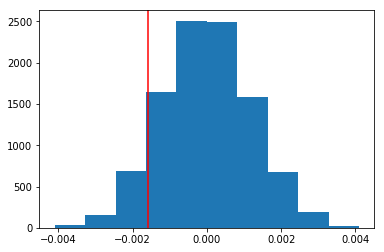

In [43]:
plt.hist(null_vals)
plt.axvline(x=obs_diff,color ='red')

In [44]:
#p_Value
(null_vals > obs_diff).mean()

0.9039

From P-value, the probability of finding the observed when null hypothesis is true.
Here P value is greater than 0.05 this means we **fail to reject null hypothesis**. That means old pages are better or equally performing well in conversion rates than new ones.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [47]:
import statsmodels.api as sm

purchase_old = df2.query("landing_page == 'old_page' and purchased == 1").shape[0]
purchase_new = df2.query("landing_page == 'new_page' and purchased == 1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

In [48]:
#using stats.proportions_ztest to compute your test statistic and p-value.
z_score, p_value = sm.stats.proportions_ztest([purchase_old, purchase_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

P value somewhat matches to the above value and its larger than 0.05 so we **failed to reject null hypothesis**